# Binary Classification Prediction Visualization

In [44]:
#!pwd
%cd ../../src

[WinError 2] The system cannot find the file specified: '../../src'
C:\Users\Felix\code\uni\UniVie\master-thesis\src


C:\Users\Felix\code\uni\UniVie\master-thesis\.venv\lib\site-packages\IPython\core\magics\osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


In [57]:
import os
import torch
import platform
import pandas as pd
import numpy as np
from itertools import compress
import matplotlib.pylab as plt
from matplotlib import font_manager as fm

import experiments.visualisation.vis_utils
from experiments.visualisation.custom_colors import *

plt.style.use('default')

font_path = r'C:\Users\Felix\AppData\Local\Microsoft\Windows\Fonts\SourceSansPro-Regular.ttf'
fm.fontManager.addfont(font_path)
source_sans_pro = fm.FontProperties(fname=font_path)

plt.rcParams['font.family'] = source_sans_pro.get_name()

In [58]:
from utils.knowledge_db import TOKENS, CODON_MAP_DNA, TISSUES
INV_CODON_MAP_DNA = {v: k for k, v in CODON_MAP_DNA.items()}
TISSUES_DICT = {k: v for k, v in enumerate(TISSUES)}

# TODO print tissue name and if tissue is already identified as GC or AT favouring based on Hernandez-Alias et al
tissue_numbers = {
    "GC": [11, 19, 10, 15],  # Kidney, Rectum, Heart, Ovary
    "AT": [13, 2, 25, 4]     # Lung, Brain, Testis, Duodenum
}

## CLASSIFICATION

In [13]:
# best model (pretrained PTRnet)
predictions_path = "/export/share/krausef99dm/runs/binary/ptrnet/31_ptrnet_freq/predictions"

path_seq_val = "/export/share/krausef99dm/data/data_test/test_9.0k_data.pkl"

In [14]:
df_val = pd.read_csv(os.path.join(predictions_path, "predictions_val_fold-0.csv"), index_col=0)

In [15]:
df_val

,tissue_ids,target,prediction
0,6,1,0.340291
1,16,0,0.534514
2,1,1,0.310510
3,8,0,0.282197
4,3,1,0.300825
...,...,...,...
2768,24,0,0.642258
2769,21,0,0.781745
2770,23,1,0.582704
2771,8,1,0.273913


In [16]:
# load val data
with open(path_seq_val, 'rb') as f:
    rna_data, tissue_ids, targets, targets_bin =  pickle.load(f)

In [17]:
# filter data
mask = torch.ones((len(rna_data)), dtype=torch.bool)
mask_bin = targets_bin > 0  # only keep low-/high-PTR samples
mask = mask_bin & mask
#targets_bin -= 1  # make binary class 0/1 encoded

mask_len = torch.tensor([len(d) <= 9000 for d in rna_data])
mask = mask_len & mask

rna_data_masked = list(compress(rna_data, mask))
tissue_ids_masked = list(compress(tissue_ids.tolist(), mask))

In [18]:
len(rna_data_masked)

2773

In [19]:
df_val

,tissue_ids,target,prediction
0,6,1,0.340291
1,16,0,0.534514
2,1,1,0.310510
3,8,0,0.282197
4,3,1,0.300825
...,...,...,...
2768,24,0,0.642258
2769,21,0,0.781745
2770,23,1,0.582704
2771,8,1,0.273913


In [20]:
#df_val["rna_data"] = rna_data_masked
df_val["prediction_bin"] = [1 if i > 0.5 else 0 for i in df_val.prediction]
df_val["correct_pred"] = df_val.target == df_val.prediction_bin

df_val["tissue_id"] = tissue_ids_masked

rna_numeric = ["".join(list(map(str, rna_data_masked[i][:, 0].tolist()))) for i in range(len(rna_data_masked))]
df_val["rna"] = ["".join([TOKENS[int(i) - 1] for i in rna]) for rna in rna_numeric]
df_val["coding_area"] = ["".join(list(map(str, rna_data_masked[i][:, 1].tolist()))) for i in range(len(rna_data_masked))]
df_val["seq_len"] = [len(rna) for rna in rna_data_masked]

In [21]:
df_val

,tissue_ids,target,prediction,prediction_bin,correct_pred,tissue_id,rna,coding_area,seq_len
0,6,1,0.340291,0,False,6,AAAATGCACAGTCCCAGTGACTGAGAGGAGGCCAGCGGAGCGCGCG...,5555555555555555555555555555555555555555555555...,2193
1,16,0,0.534514,1,False,16,AAAATGCACAGTCCCAGTGACTGAGAGGAGGCCAGCGGAGCGCGCG...,5555555555555555555555555555555555555555555555...,2193
2,1,1,0.310510,0,False,1,TCCCCTTGGCCCTCCCTTACCGCACGGTCTCTGGCCAGCCGTGGCC...,5555555555555555555555555555555555555555555555...,1761
3,8,0,0.282197,0,True,8,TCCCCTTGGCCCTCCCTTACCGCACGGTCTCTGGCCAGCCGTGGCC...,5555555555555555555555555555555555555555555555...,1761
4,3,1,0.300825,0,False,3,GCGTCCGCGCCATCAGGCCCGAGATAGCGGCGAGGTCCGCTTTCAG...,5555555555555555555555555555555555555555555555...,2767
...,...,...,...,...,...,...,...,...,...
2768,24,0,0.642258,1,False,24,CTCGGCGATGAGCTAAGACGCTGTTTCAGAGCGTTTGGGTCCTCTG...,5555555555555555555555555555555555555555555555...,1998
2769,21,0,0.781745,1,False,21,ACATTGGGGCGGGATGTGGGAGCGGCTGAACTGCGCAGCAGAGGAC...,5555555555555123123123123123123123123123123123...,3595
2770,23,1,0.582704,1,True,23,ACATTGGGGCGGGATGTGGGAGCGGCTGAACTGCGCAGCAGAGGAC...,5555555555555123123123123123123123123123123123...,3595
2771,8,1,0.273913,0,False,8,GGAGTCTGCGCTCTGGTTCGGGCTGCGGCTGCGGCTGCGGCTGCGG...,5555555555555555555555555555555555555555555555...,8143


## Checkpoint

In [22]:
# store df_val
df_val.to_csv("../experiments/visualisation/data/ptrnet_31_preds_extended.csv")

In [60]:
# load df_val
df = pd.read_csv("../experiments/visualisation/data/ptrnet_31_preds_extended.csv", index_col=0)

## Feature engineering

### 3' and 5' UTR lengths

In [66]:
df.loc[:, "5_utr_len"] = [seq.count("5") for seq in df.coding_area]
df.loc[:, "3_utr_len"] = [seq.count("3") for seq in df.coding_area]

### Total GC content

In [67]:
# legacy
def compute_gc_content(encoded_str: str) -> float:
    """
    Compute GC content from a string of token indices (as characters).
    """
    decoded = [TOKENS[int(ch)-1] for ch in encoded_str if ch.isdigit()]
    gc_count = sum(1 for base in decoded if base in ['G', 'C'])
    valid_bases = sum(1 for base in decoded if base in ['A', 'C', 'G', 'T'])
    return gc_count / valid_bases if valid_bases > 0 else 0.0

In [68]:
# new
def gc_ending_codon_fraction(seq):
    codons = [seq[i:i+3] for i in range(0, len(seq) - len(seq) % 3, 3)]
    gc_ending = [c for c in codons if c[-1] in {'G', 'C'}]
    return len(gc_ending) / len(codons) if codons else 0

In [69]:
df.loc[:, "gc_content"] = df["rna"].apply(gc_ending_codon_fraction)

In [70]:
df

,tissue_ids,target,prediction,prediction_bin,correct_pred,tissue_id,rna,coding_area,seq_len,5_utr_len,3_utr_len,gc_content
0,6,1,0.340291,0,False,6,AAAATGCACAGTCCCAGTGACTGAGAGGAGGCCAGCGGAGCGCGCG...,5555555555555555555555555555555555555555555555...,2193,209,426,0.461012
1,16,0,0.534514,1,False,16,AAAATGCACAGTCCCAGTGACTGAGAGGAGGCCAGCGGAGCGCGCG...,5555555555555555555555555555555555555555555555...,2193,209,426,0.461012
2,1,1,0.310510,0,False,1,TCCCCTTGGCCCTCCCTTACCGCACGGTCTCTGGCCAGCCGTGGCC...,5555555555555555555555555555555555555555555555...,1761,142,416,0.504259
3,8,0,0.282197,0,True,8,TCCCCTTGGCCCTCCCTTACCGCACGGTCTCTGGCCAGCCGTGGCC...,5555555555555555555555555555555555555555555555...,1761,142,416,0.504259
4,3,1,0.300825,0,False,3,GCGTCCGCGCCATCAGGCCCGAGATAGCGGCGAGGTCCGCTTTCAG...,5555555555555555555555555555555555555555555555...,2767,49,310,0.364425
...,...,...,...,...,...,...,...,...,...,...,...,...
2768,24,0,0.642258,1,False,24,CTCGGCGATGAGCTAAGACGCTGTTTCAGAGCGTTTGGGTCCTCTG...,5555555555555555555555555555555555555555555555...,1998,127,479,0.373874
2769,21,0,0.781745,1,False,21,ACATTGGGGCGGGATGTGGGAGCGGCTGAACTGCGCAGCAGAGGAC...,5555555555555123123123123123123123123123123123...,3595,13,592,0.319699
2770,23,1,0.582704,1,True,23,ACATTGGGGCGGGATGTGGGAGCGGCTGAACTGCGCAGCAGAGGAC...,5555555555555123123123123123123123123123123123...,3595,13,592,0.319699
2771,8,1,0.273913,0,False,8,GGAGTCTGCGCTCTGGTTCGGGCTGCGGCTGCGGCTGCGGCTGCGG...,5555555555555555555555555555555555555555555555...,8143,201,745,0.395357


## Analysis

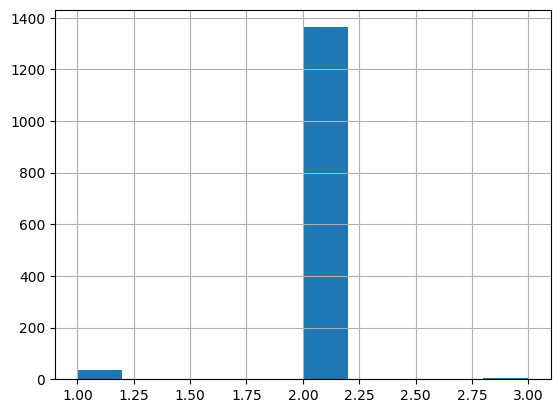

In [77]:
# almost all sequences appear twice (in val set)
df.groupby("rna").correct_pred.count().hist()

<Axes: >

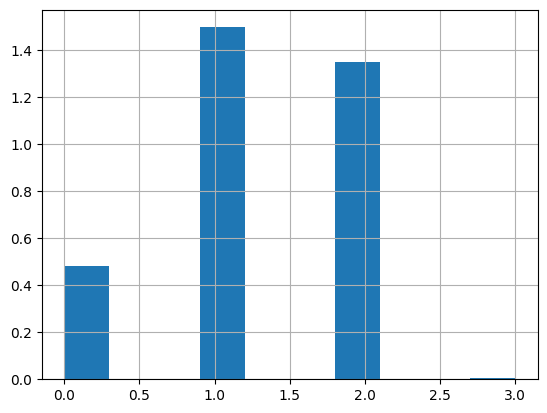

In [78]:
df.groupby("rna").correct_pred.sum().hist(density=True)
# 0: low- and high PTR sample of mRNA classified wrong: around 17%
# 1: only one of both is classified correctly: around 43%
# 2: both are correctly predicted: 39%

### Descriptive analysis

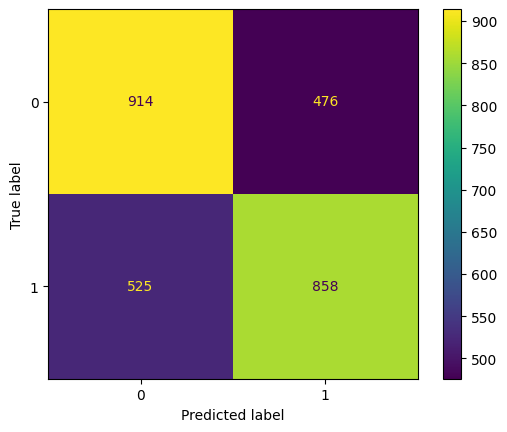

In [79]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(df.target, df.prediction_bin)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [86]:
# Distribution between correctly and wrongly classified samples
df.groupby("correct_pred").seq_len.describe()

,count,mean,std,min,25%,50%,75%,max
correct_pred,,,,,,,,
False,1001.0,3330.860140,1944.378255,355.0,1842.0,2825.0,4581.0,8992.0
True,1772.0,3181.146727,1901.260118,355.0,1734.0,2687.0,4384.0,8992.0


### Visual Analysis

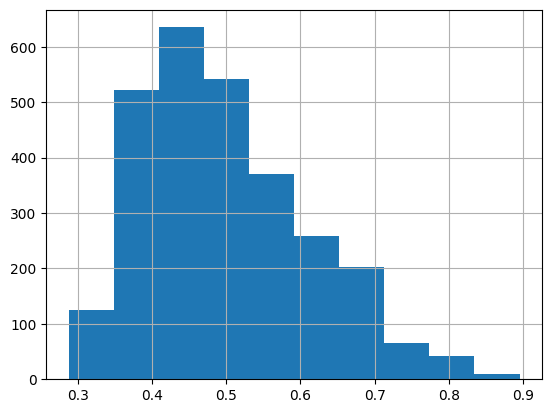

In [89]:
df.gc_content.hist()
plt.show()

#### Distribution of Predictions

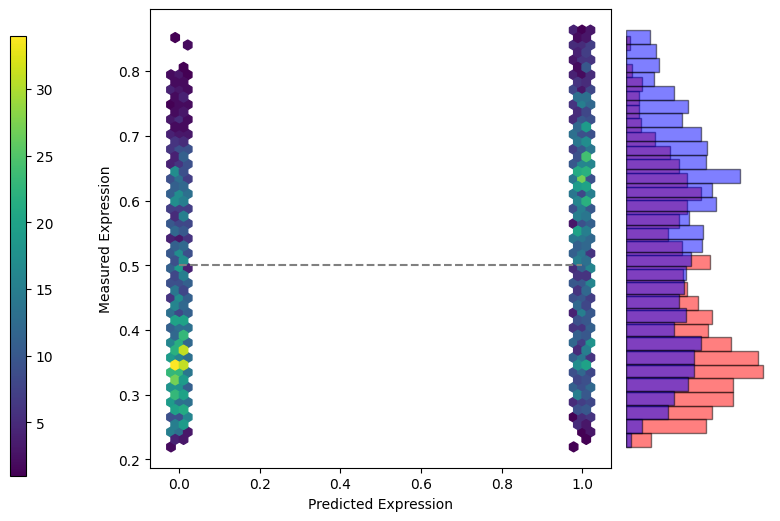

In [90]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

category_colors = {
    0: "red",
    1: "blue",
}

# Example data
np.random.seed(42)
x = df['target']
x_jitter = x + np.random.normal(0, 0.02, len(x))
x_jitter = np.clip(x_jitter, x - 0.02, x + 0.02)

y = df['prediction']

# Calculate correlations
pearson_corr, _ = pearsonr(x, y)
spearman_corr, _ = spearmanr(x, y)

# Create the figure
fig = plt.figure(figsize=(8, 8))
gs = fig.add_gridspec(4, 4, hspace=0.1, wspace=0.1)

# Main plot
ax_main = fig.add_subplot(gs[1:4, 0:3])
hb = ax_main.hexbin(x_jitter, y, gridsize=50, cmap='viridis', mincnt=1)
# ax_main.plot([x.min(), x.max()], [x.min(), x.max()], 'gray', linestyle='--')
ax_main.plot([x.min(), x.max()], [0.5, 0.5], 'gray', linestyle='--')
ax_main.set_xlabel('Predicted Expression')
ax_main.set_ylabel('Measured Expression')

# Add colorbar on the left
cax = fig.add_axes([-0.05, 0.1, 0.02, 0.55])  # [left, bottom, width, height]
cb = fig.colorbar(hb, cax=cax, orientation='vertical')
# cb.set_label('Density')

# Add correlation text
# n_samples = len(x)
# ax_main.text(0.05, 0.95, f"Pearson's r = {pearson_corr:.3f}\nSpearman's r = {spearman_corr:.2f}\nN = {n_samples}",
#              transform=ax_main.transAxes, verticalalignment='top', fontsize=12)

# Top histogram
# ax_top = fig.add_subplot(gs[0, 0:3], sharex=ax_main)
# ax_top.hist(x, bins=30, color='gray', edgecolor='black', alpha=0.7)
# ax_top.axis('off')

# Right histogram (rotated)
ax_right = fig.add_subplot(gs[1:4, 3], sharey=ax_main)
# ax_right.hist(y, bins=30, color='gray', edgecolor='black', alpha=0.7, orientation='horizontal')
for category in np.unique(x):
    group_y = y[x == category]
    ax_right.hist(group_y, bins=30, color=category_colors[category], edgecolor='black', alpha=0.5, orientation='horizontal', label=category)

ax_right.axis('off')

plt.show()

#### mRNA specific predictive power

In [97]:
# Compute a Series indicating if an mRNA is only wrongly classified (sum==0)
only_wrong = df.groupby("rna")["correct_pred"].sum() == 0

# Map the boolean result to a new column in the original df
df.loc[:, "all_wrong"] = df["rna"].map(only_wrong)

In [98]:
all_wrong_sample = df[df["all_wrong"]]
all_wrong_sample.describe()

,tissue_ids,target,prediction,prediction_bin,tissue_id,seq_len,5_utr_len,3_utr_len,gc_content
count,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000
mean,14.654912,0.501259,0.500639,0.498741,14.654912,3425.964736,191.037783,555.098237,0.488209
std,8.299891,0.500629,0.138037,0.500629,8.299891,1903.411078,179.219509,381.262016,0.096663
min,0.000000,0.000000,0.238144,0.000000,0.000000,463.000000,8.000000,72.000000,0.314428
25%,8.000000,0.000000,0.378293,0.000000,8.000000,1942.000000,72.000000,300.000000,0.410490
50%,15.000000,1.000000,0.498779,0.000000,15.000000,3095.000000,134.000000,444.000000,0.474474
75%,22.000000,1.000000,0.617698,1.000000,22.000000,4644.000000,275.000000,707.000000,0.540337
max,28.000000,1.000000,0.837216,1.000000,28.000000,8846.000000,1449.000000,1941.000000,0.853093


In [104]:
# Analysis of very confident mistakes
tau = 0.3

confident_mistakes = df[(~df.correct_pred) &
   ( ((df.target == 1) & (df.prediction < tau )) |
     ((df.target == 0) & (df.prediction > 1 - tau))
   )
]

confident_mistakes.groupby("all_wrong").describe()

tissue_ids                                                  target  \
               count       mean       std  min  25%   50%   75%   max  count   
all_wrong                                                                      
False           85.0  11.223529  7.578756  1.0  8.0  11.0  16.0  27.0   85.0   
True            47.0  11.425532  8.707180  1.0  2.0  11.0  16.0  28.0   47.0   

                     ... 3_utr_len         gc_content                      \
               mean  ...       75%     max      count      mean       std   
all_wrong            ...                                                    
False      0.588235  ...     595.0  1756.0       85.0  0.503365  0.122945   
True       0.531915  ...     645.0  1632.0       47.0  0.518166  0.105873   

                                                             
                min       25%       50%       75%       max  
all_wrong                                                    
False      0.310734  0.414683  0.465995  0.582677  0.823782  
True       0.327504  0.422297  0.514894  0.600945  0.724036  

[2 rows x 72 columns]

In [105]:
df[~df.index.isin(confident_mistakes.index)].groupby("all_wrong").seq_len.describe()

,count,mean,std,min,25%,50%,75%,max
all_wrong,,,,,,,,
False,2291.0,3217.473592,1925.308393,355.0,1747.0,2719.0,4428.50,8992.0
True,350.0,3500.288571,1913.205225,463.0,2034.0,3183.5,4691.25,8846.0


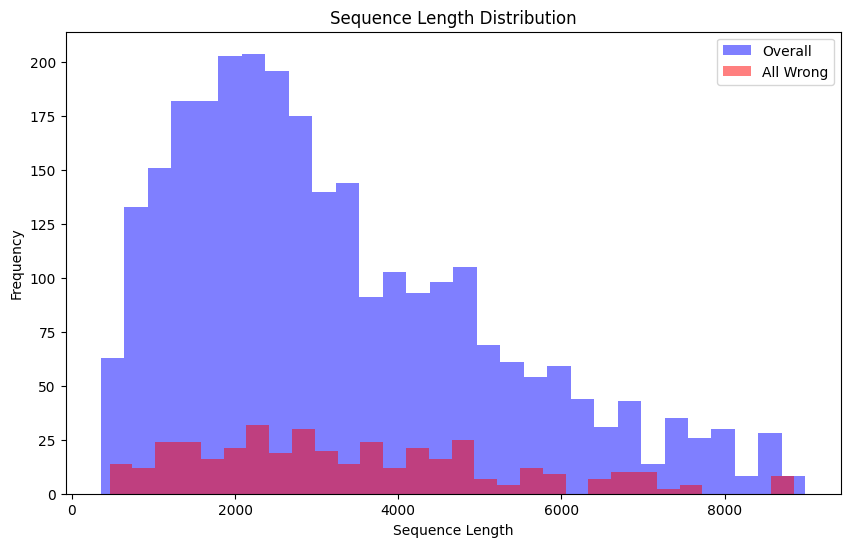

In [113]:
plt.figure(figsize=(10, 6))

# Histogram for all samples
plt.hist(df['seq_len'], bins=30, alpha=0.5, label='Overall', color='blue')

# Histogram for samples where 'all_wrong' is True
plt.hist(df.loc[df['all_wrong'], 'seq_len'], bins=30, alpha=0.5, label='All Wrong', color='red')

plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.legend()
plt.title('Sequence Length Distribution')
plt.show()

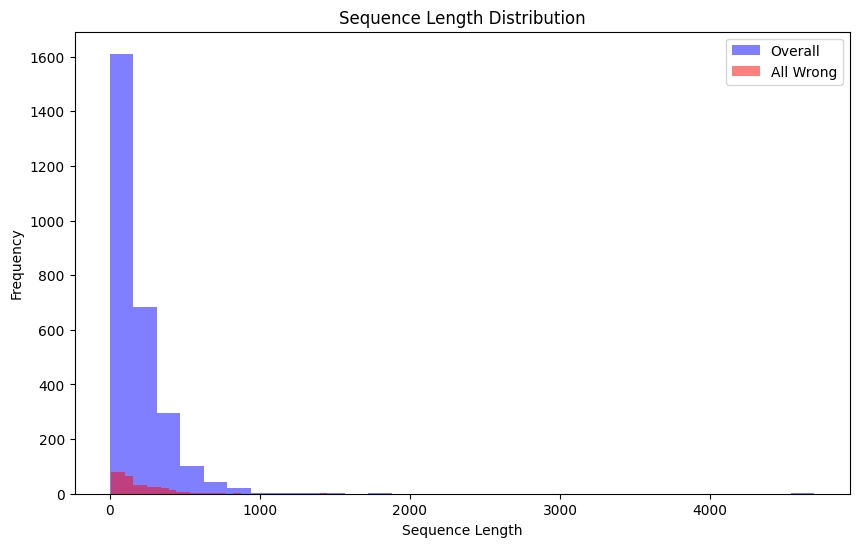

In [115]:
plt.figure(figsize=(10, 6))

# Histogram for all samples
plt.hist(df['5_utr_len'], bins=30, alpha=0.5, label='Overall', color='blue')

# Histogram for samples where 'all_wrong' is True
plt.hist(df.loc[df['all_wrong'], '5_utr_len'], bins=30, alpha=0.5, label='All Wrong', color='red')

plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.legend()
plt.title('Sequence Length Distribution')
plt.show()

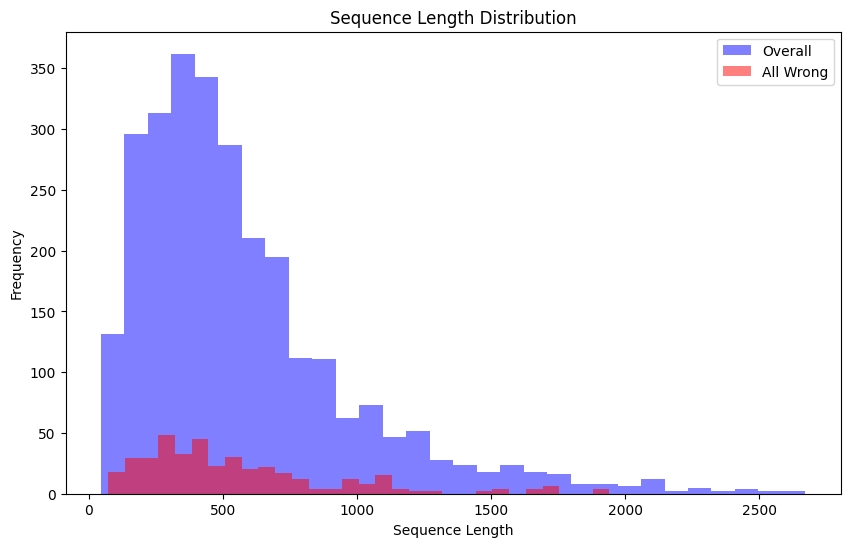

In [116]:
plt.figure(figsize=(10, 6))

# Histogram for all samples
plt.hist(df['3_utr_len'], bins=30, alpha=0.5, label='Overall', color='blue')

# Histogram for samples where 'all_wrong' is True
plt.hist(df.loc[df['all_wrong'], '3_utr_len'], bins=30, alpha=0.5, label='All Wrong', color='red')

plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.legend()
plt.title('Sequence Length Distribution')
plt.show()

## Show correlations

In [117]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches

def plot_correlations(df, feature_name, tissue_id=None):
    df_subset = df
    if tissue_id is not None:
        df_subset = df[df.tissue_id.isin([tissue_id])].copy()

    y_true = df_subset.target
    y_pred = df_subset.prediction
    feature = df_subset[feature_name]

    print("Tissue displayed:", TISSUES_DICT[tissue_id], f"({tissue_id})")
    if tissue_id in tissue_numbers["GC"]:
        print("NOTE: Tissue GC boosted acc to Hernandez et al!")
    if tissue_id in tissue_numbers["AT"]:
        print("NOTE: Tissue AT boosted acc to Hernandez et al!")
    print("Counts per target:", df.groupby(["tissue_id", "target"]).prediction.count().loc[tissue_id])
    print("Correlation", np.corrcoef(feature, y_pred)[0])

    # Define colors for class 0 and 1
    color_map = {0: 'tab:blue', 1: 'tab:red'}
    colors = y_true.map(color_map)

    plt.figure(figsize=(8, 6))

    # Shaded regions
    #plt.axhspan(0.5, 1.0, color='red', alpha=0.05)
    #plt.axhspan(0.0, 0.5, color='blue', alpha=0.05)

    if max(y_pred) > 0.5:
        plt.axhspan(0.5, max(y_pred) * 1.1, color='red', alpha=0.05)
    if min(y_pred) < 0.5:
        plt.axhspan(min(y_pred) * 0.9, 0.5, color='blue', alpha=0.05)

    # Scatter plot
    plt.scatter(feature, y_pred, c=colors, alpha=0.8, linewidth=0.5)

    # Axis labels and threshold line
    plt.xlabel(feature_name)
    plt.ylabel("Predicted Score")
    plt.plot([min(feature)*0.9, max(feature)*1.1], [0.5, 0.5], color='grey', linestyle='--')
    plt.title(f"Predicted Score vs. {feature_name}")

    # Legend
    legend_elements = [
        mpatches.Patch(color='tab:red', label='High PTR (1)'),
        mpatches.Patch(color='tab:blue', label='Low PTR (0)')
    ]
    plt.legend(handles=legend_elements, title="True Class", loc="best")

    plt.tight_layout()
    plt.show()

In [150]:
nr_iter = iter(range(29))

Tissue displayed: Adrenal (0)
Counts per target: target
0    24
1    23
Name: prediction, dtype: int64
Correlation [ 1.         -0.35280048]


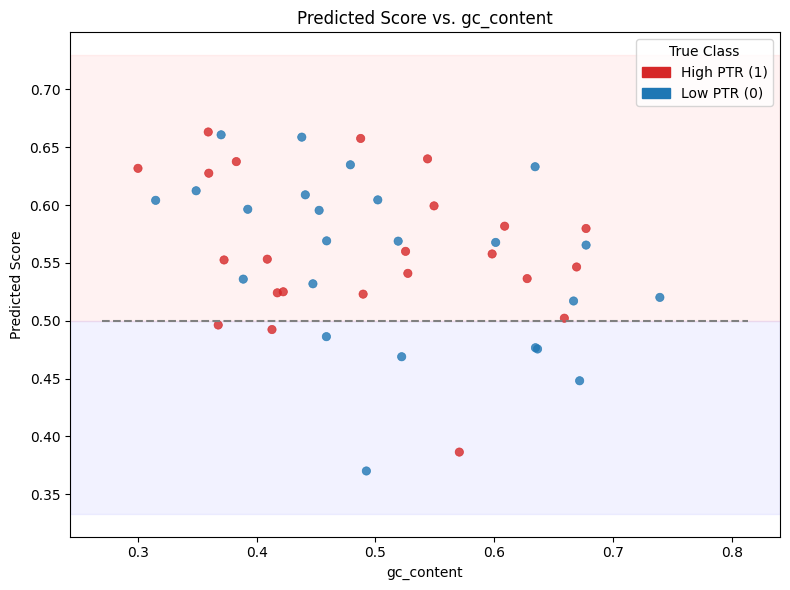

In [151]:
# blue should be below the line
plot_correlations(df, "gc_content", next(nr_iter))  # gc_content, seq_len

Tissue displayed: Kidney (11)
NOTE: Tissue GC boosted acc to Hernandez et al!
Counts per target: target
0    66
1    62
Name: prediction, dtype: int64
Correlation [1.         0.73605699]


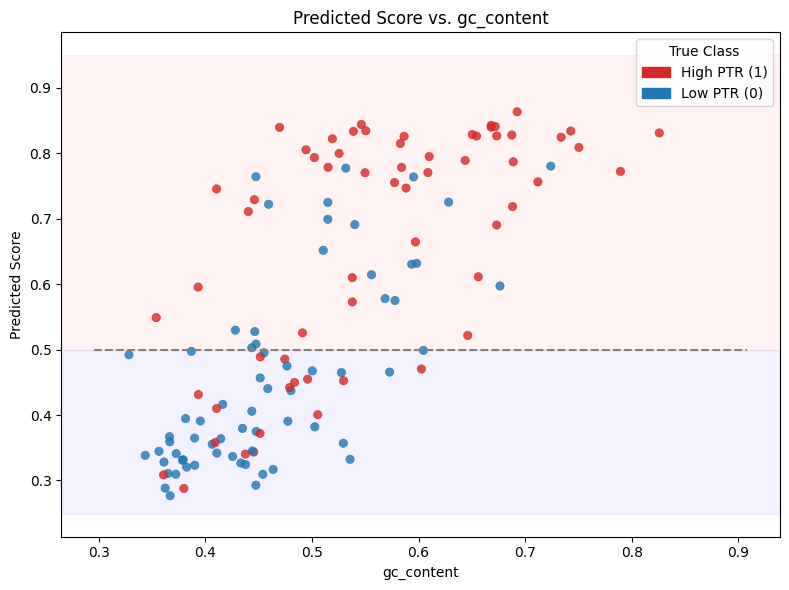

In [152]:
# blue should be below the line
plot_correlations(df, "gc_content", 11)  # gc_content, seq_len

#### Correlation with specific sequences

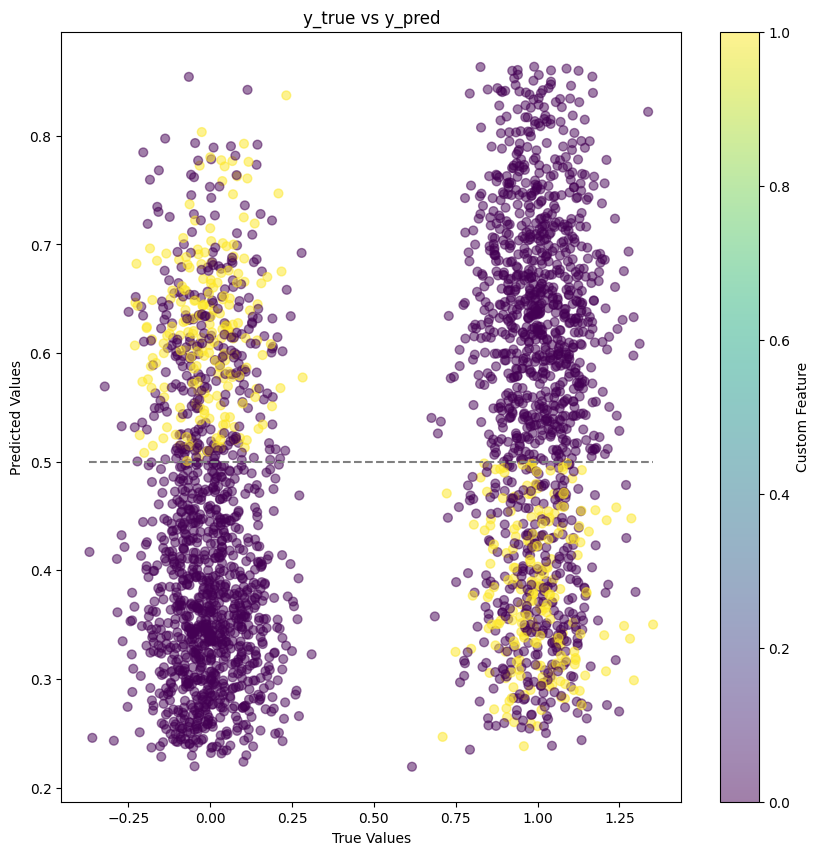

In [154]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 10))

y_true = df.target + np.random.normal(0, 0.1, len(df.target))
y_pred = df.prediction
seq_lengths = df.seq_len

cmap = plt.cm.viridis  # Choose a colormap (e.g., viridis, plasma, etc.)

# Scatter plot with colors

scatter = plt.scatter(y_true, y_pred, alpha=0.5, s=40, c=df.all_wrong, cmap=cmap)  # ALL_WRONG

plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('y_true vs y_pred')

# Add a colorbar associated with the scatter plot
cbar = plt.colorbar(scatter)
cbar.set_label('Custom Feature')

min_val = min(min(y_true), min(y_pred))
max_val = max(max(y_true), max(y_pred))
plt.plot([min_val, max_val], [0.5, 0.5], color='grey', linestyle='--')

plt.show()

# Does the model mainly fail for specific sequences (yellow: prediction for both low and high ptr was wrong)

#### Correlations with sequence length

In [155]:
import matplotlib.pyplot as plt
import numpy as np

def plot_corr_with_seq_len(df, selected_tissues=[]):
    plt.figure(figsize=(10, 10))
    if selected_tissues:
        df = df[df.tissue_id.isin(selected_tissues)].copy()
    
    y_true = df.target + np.random.normal(0, 0.1, len(df.target))
    y_pred = df.prediction
    seq_lengths = df.seq_len
    
    # Normalize sequence lengths for coloring
    norm = plt.Normalize(min(seq_lengths), max(seq_lengths))
    cmap = plt.cm.viridis  # Choose a colormap (e.g., viridis, plasma, etc.)
    
    # Scatter plot with colors
    scatter = plt.scatter(y_true, y_pred, alpha=0.5, s=40, c=seq_lengths, cmap=cmap, norm=norm)
    
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('y_true vs y_pred')
    
    # Add a colorbar associated with the scatter plot
    cbar = plt.colorbar(scatter)
    cbar.set_label('Sequence Length')
    
    min_val = min(min(y_true), min(y_pred))
    max_val = max(max(y_true), max(y_pred))
    plt.plot([min_val, max_val], [0.5, 0.5], color='grey', linestyle='--')
    
    plt.show()

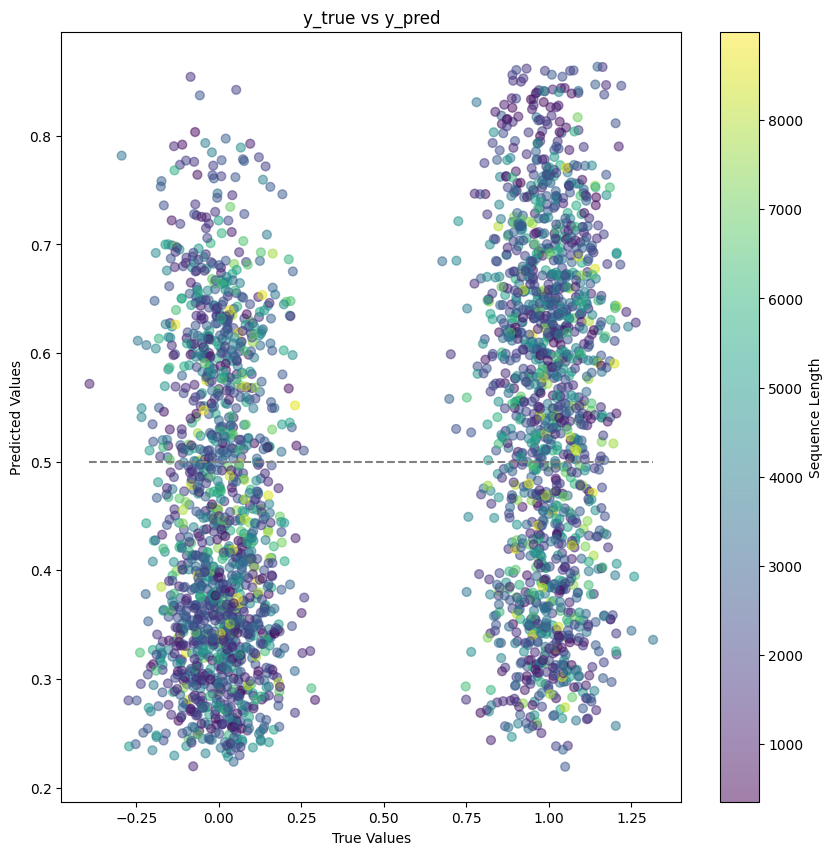

In [156]:
import matplotlib.pyplot as plt
import numpy as np

plot_corr_with_seq_len(df)
# FREQ

In [157]:
nr_iter = iter(range(28))

[0]
target
0    24
1    23
Name: prediction, dtype: int64


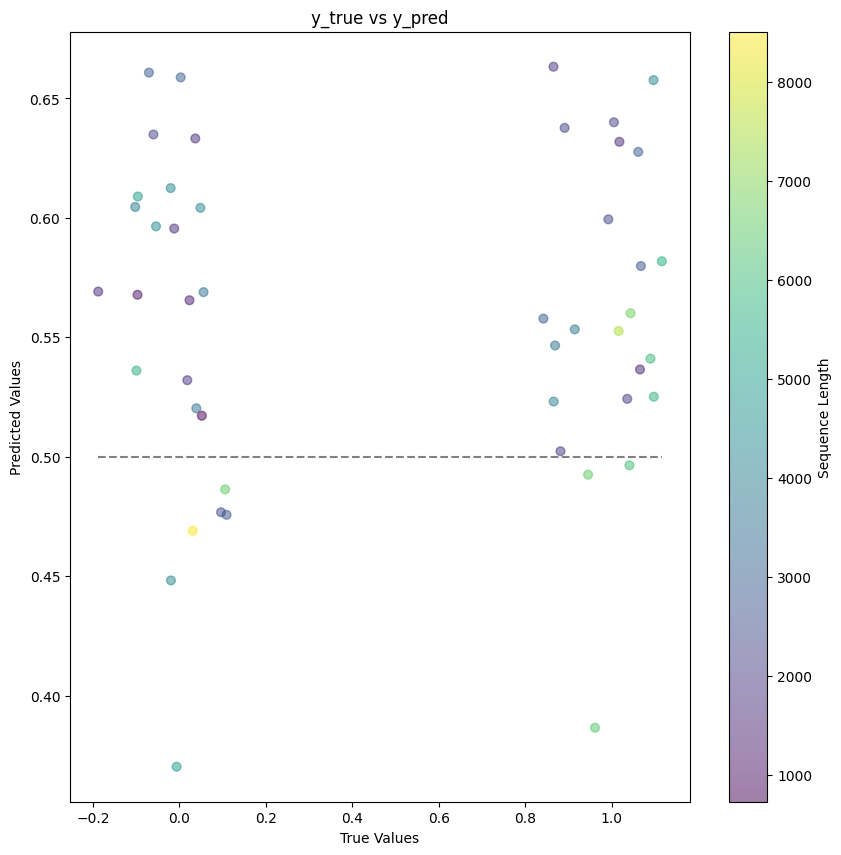

In [158]:
nr = next(nr_iter)
selected_tissues = [nr]
print(selected_tissues)
print(df.groupby(["tissue_id", "target"]).prediction.count().loc[nr])

plot_corr_with_seq_len(df, selected_tissues)

#### Correlation with GC content

In [166]:
import matplotlib.pyplot as plt
import numpy as np

# Filter dataframe
def plot_corr_with_gc_content(df, selected_tissues=None):
    plt.figure(figsize=(10, 10))
    if selected_tissues:
        df = df[df.tissue_id.isin(selected_tissues)].copy()
    
    y_true = df.target + np.random.normal(0, 0.1, len(df.target))
    y_pred = df.prediction
    seq_lengths = df.gc_content
    
    # Normalize sequence lengths for coloring
    norm = plt.Normalize(min(seq_lengths), max(seq_lengths))
    cmap = plt.cm.viridis  # Choose a colormap (e.g., viridis, plasma, etc.)
    
    # Scatter plot with colors
    scatter = plt.scatter(y_true, y_pred, alpha=0.4, s=40, c=seq_lengths, cmap=cmap, norm=norm)
    
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('y_true vs y_pred')
    
    # Add a colorbar associated with the scatter plot
    cbar = plt.colorbar(scatter)
    cbar.set_label('GC Content')
    
    min_val = min(min(y_true), min(y_pred))
    max_val = max(max(y_true), max(y_pred))
    plt.plot([min_val, max_val], [0.5, 0.5], color='grey', linestyle='--')
    
    plt.show()

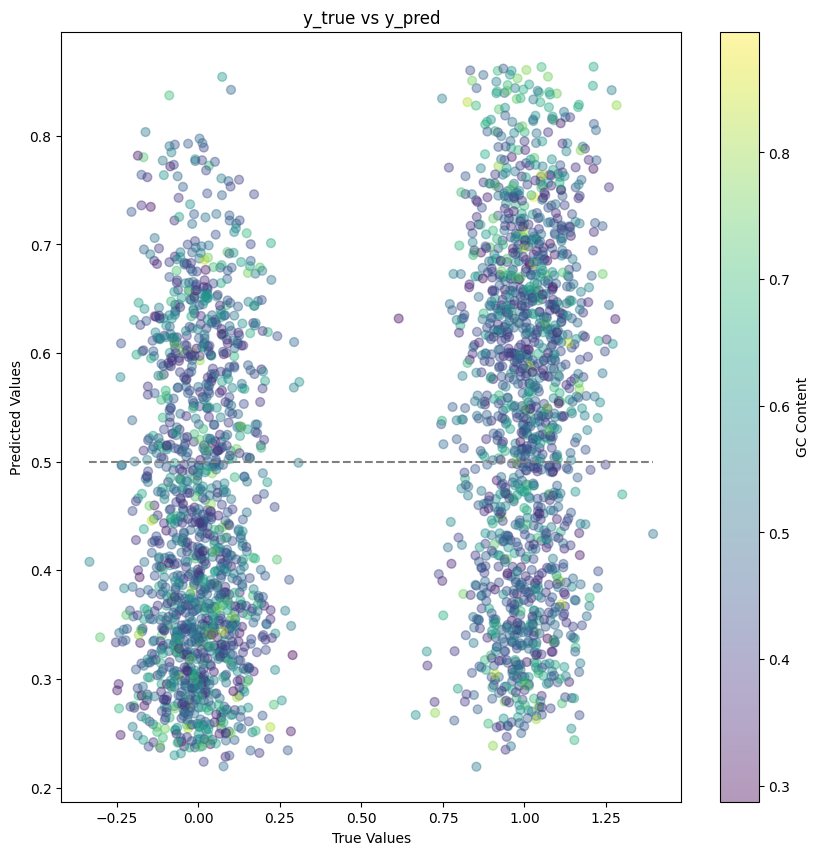

In [167]:
plot_corr_with_gc_content(df)

In [160]:
nr_iter = iter(range(29))

[1, 2, 3, 4, 5]


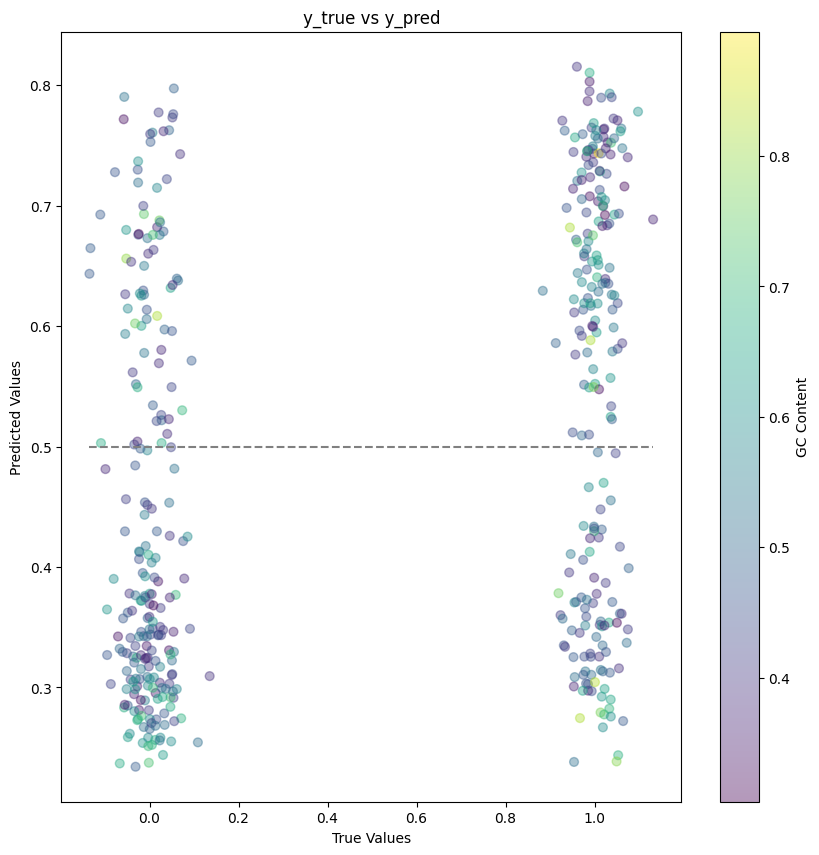

In [161]:
# Choose subset of tissue IDs to analyze

# nr = next(nr_iter)
selected_tissues = [1,2,3,4,5]
print(selected_tissues)
# print(df.groupby(["tissue_id", "target"]).prediction.count().loc[nr])

plot_corr_with_gc_content(df, selected_tissues)

#### Correlation among tissue ids

In [211]:
nr_iter = iter(range(29))

Tissue displayed: Adrenal (0)
[[ 6 18]
 [ 3 20]]


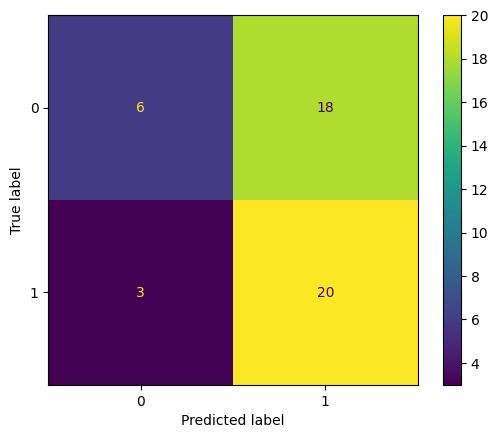

In [212]:
# Confusion matrix per tissue
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

tissue_id = next(nr_iter)

print("Tissue displayed:", TISSUES_DICT[tissue_id], f"({tissue_id})")
subset_df = df[df.tissue_id.isin([tissue_id])].copy()

if tissue_id in tissue_numbers["GC"]:
        print("NOTE: Tissue GC boosted acc to Hernandez et al!")
if tissue_id in tissue_numbers["AT"]:
    print("NOTE: Tissue AT boosted acc to Hernandez et al!")

cm = confusion_matrix(subset_df.target, subset_df.prediction_bin)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [171]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def corr_among_tissues(selected_tissues):
    # Filter dataframe
    subset_df = df[df.tissue_id.isin(selected_tissues)].copy()

    # Check if the subset is non-empty
    if subset_df.empty:
        raise ValueError("No data available for the selected tissue IDs.")

    plt.figure(figsize=(10, 10))

    # Generate y_true (adding a small uniform noise) and y_pred
    y_true = subset_df.target + np.random.uniform(0, 0.8, len(subset_df))
    y_pred = subset_df.prediction

    # Fix the y-scale to [0, 1]
    #plt.ylim(0, 1)

    # Get unique tissue ids and sort them
    unique_tissues = sorted(subset_df.tissue_id.unique())

    # Define a list of markers to cycle through
    markers = ['o', 's', '^', 'D']#, 'v']#, 'P', '*', 'X', 'h', 'H', '8', 'p', 'd']
    # Get a colormap with as many distinct colors as there are tissues (using a colormap that supports many colors)
    # cmap = plt.get_cmap('nipy_spectral', len(unique_tissues))
    cmap = plt.get_cmap('tab10' if len(unique_tissues) <= 10 else 'tab20', max(len(unique_tissues), 1))

    # Plot each tissue's data separately with its own color and marker
    for i, tissue in enumerate(unique_tissues):
        mask = subset_df.tissue_id == tissue
        plt.scatter(
            y_true[mask],
            y_pred[mask],
            label=f'Tissue {tissue}',
            alpha=0.5,
            s=40,
            c=[cmap(i)],
            marker=markers[i % len(markers)]
        )

    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('y_true vs y_pred by Selected Tissue IDs')

    # Add a legend outside the plot area for clarity
    plt.legend(title='Tissue ID', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Optionally, add a horizontal line at y = 0.5 for reference
    min_val = min(np.min(y_true), np.min(y_pred))
    max_val = max(np.max(y_true), np.max(y_pred))
    plt.plot([min_val, max_val], [0.5, 0.5], color='grey', linestyle='--')

    plt.tight_layout()
    plt.show()

In [172]:
nr_iter = iter(range(29))

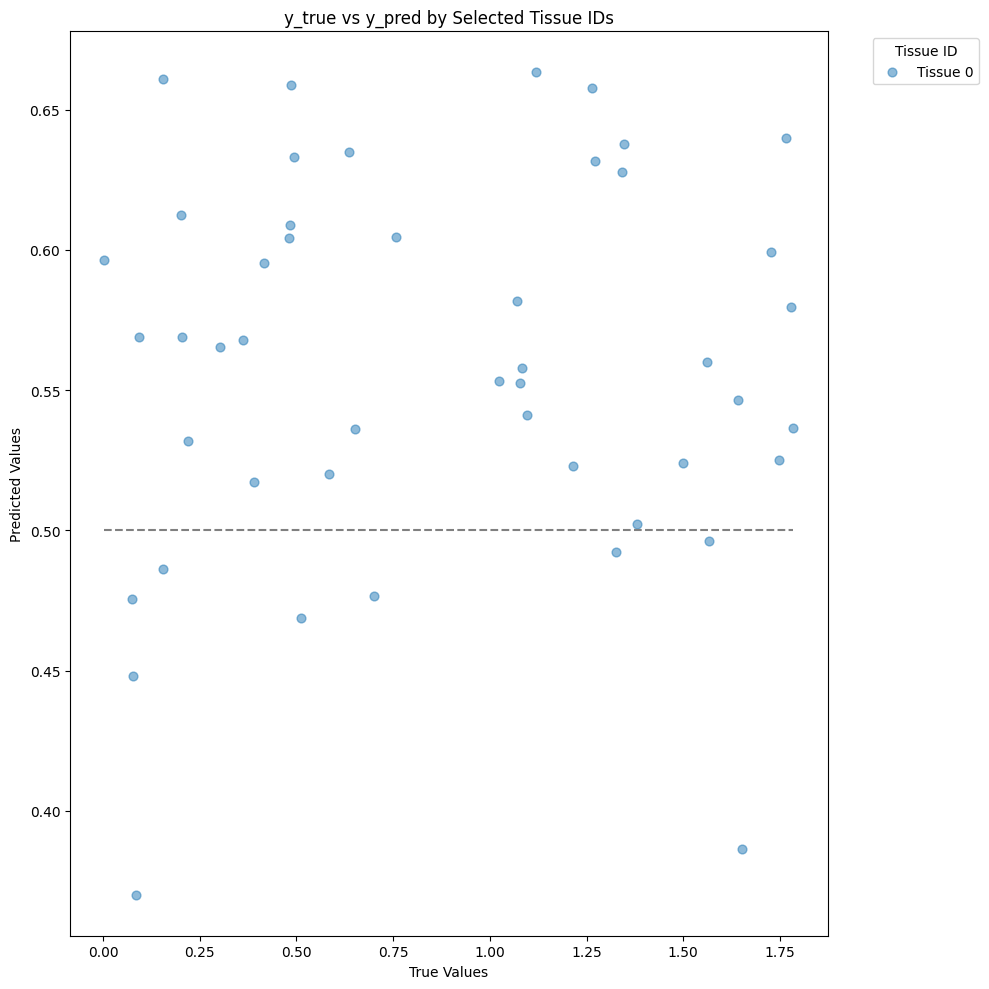

In [173]:
corr_among_tissues([next(nr_iter)])

In [ ]:
# Choose subset of tissue IDs to analyze
#selected_tissues = list(range(10))
selected_tissues = list(range(10,20))
#selected_tissues = list(range(20,29))

corr_among_tissues(selected_tissues)

#### Correlation with tissue type

In [240]:
# for vis see above
df.groupby(["tissue_id", "target"]).prediction.count()

tissue_id  target
0          0         18
           1         29
1          0         74
           1         31
2          0         39
           1         86
3          0         39
           1         31
4          0         28
           1         21
5          0         32
           1         23
6          0         45
           1         26
7          0         28
           1         40
8          0         84
           1         39
9          0         29
           1         17
10         0         61
           1         46
11         0         44
           1         55
12         0         47
           1         42
13         0         41
           1         84
14         0         33
           1         45
15         0         59
           1         52
16         0         79
           1         49
17         0         34
           1         37
18         0         33
           1         28
19         0         25
           1         35
20         0         3

In [245]:
# If downsample tissue wise to less dominant class, number of samples in val set would shrink to 1896 from 2352
ls = df.groupby(["tissue_id", "target"]).prediction.count().to_list()
tpls = [(ls[i], ls[i+1]) for i in range(0, len(ls), 2)]
2 * sum([min(tpl) for tpl in tpls])

1896

In [248]:
sum(ls)

2352

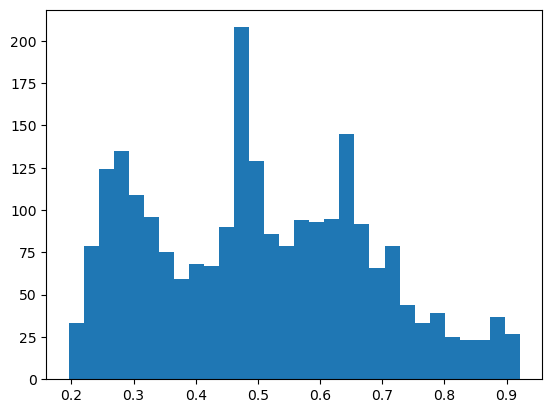

In [250]:
plt.hist(df.prediction, bins=30)
plt.show()